In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------- Fast corruption check and auto-delete --------
def check_and_clean_images_fast(folder):
    print(f"\n🔍 Checking images in: {folder}")
    corrupted = []
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_name in tqdm(os.listdir(class_path), desc=f"Checking {class_name}"):
                img_path = os.path.join(class_path, img_name)
                try:
                    # Fast check: try opening first 10 bytes only
                    with open(img_path, "rb") as f:
                        if not f.read(10):
                            raise ValueError("Empty file")
                except:
                    corrupted.append(img_path)
                    os.remove(img_path)  # Delete corrupted file
    if corrupted:
        print("❌ Deleted corrupted images:")
        for c in corrupted:
            print(c)
    else:
        print("✅ No corrupted images found!")

# -------- Count images per class --------
def count_images(folder):
    print(f"\n📊 Counting images in: {folder}")
    counts = {}
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    print(counts)
    return counts

# -------- Visualize random samples in a grid --------
def visualize_samples_grid(folder, num_samples=5):
    print(f"\n🖼️ Showing {num_samples} random samples from {folder}")
    class_names = [c for c in os.listdir(folder) if os.path.isdir(os.path.join(folder, c))]

    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        class_name = random.choice(class_names)
        class_path = os.path.join(folder, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)

        import cv2
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    plt.show()

# -------- Run all steps --------
train_folder = r"C:/Users/fomal/Downloads/archive/final_dataset/train"
val_folder   = r"C:/Users/fomal/Downloads/archive/final_dataset/validation"

# Step 1A: Check & Clean corrupted images
check_and_clean_images_fast(train_folder)
check_and_clean_images_fast(val_folder)

# Step 1B: Count images per class
train_counts = count_images(train_folder)
val_counts = count_images(val_folder)

# Step 1C: Visualize some random images
visualize_samples_grid(train_folder, num_samples=5)
visualize_samples_grid(val_folder, num_samples=5)


In [ ]:
import os
import cv2
import tensorflow as tf
from tqdm import tqdm

# -------- Parameters --------
img_height, img_width = 64, 64

# -------- Source & Destination Folders --------
train_src = r"C:/Users/fomal/Downloads/archive/final_dataset/train"
val_src   = r"C:/Users/fomal/Downloads/archive/final_dataset/validation"

train_dst = r"C:/Users/fomal/Downloads/archive/final_dataset_resized/train"
val_dst   = r"C:/Users/fomal/Downloads/archive/final_dataset_resized/validation"

# -------- Function to preprocess & save images --------
def preprocess_and_save(src_dir, dst_dir, grayscale=True):
    os.makedirs(dst_dir, exist_ok=True)
    class_names = [c for c in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, c))]

    folder_total = 0
    folder_done = 0

    print(f"\nStarting preprocessing for folder: {src_dir}")
    for class_name in class_names:
        src_class_path = os.path.join(src_dir, class_name)
        dst_class_path = os.path.join(dst_dir, class_name)
        os.makedirs(dst_class_path, exist_ok=True)

        img_list = os.listdir(src_class_path)
        total_images = len(img_list)
        folder_total += total_images

        for img_name in tqdm(img_list, desc=f"Processing {class_name}", unit="img"):
            src_path = os.path.join(src_class_path, img_name)
            dst_path = os.path.join(dst_class_path, img_name)

            # Load image
            img = cv2.imread(src_path)
            if img is None:
                continue  # Skip corrupted images

            # Convert to grayscale if needed
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize
            img = cv2.resize(img, (img_width, img_height))

            # Save processed image
            cv2.imwrite(dst_path, img)

            folder_done += 1
            if folder_done % 15000 == 0:  # Print progress every 15,000 images
                print(f"Processed {folder_done}/{folder_total} images so far...")

    print(f"✅ Finished preprocessing folder: {src_dir}")
    print(f"Total images processed: {folder_done}/{folder_total}\n")

# -------- Preprocess train & validation sets --------
preprocess_and_save(train_src, train_dst, grayscale=True)
preprocess_and_save(val_src, val_dst, grayscale=True)

# -------- Function to create tf.data.Dataset --------
def create_tf_dataset(data_dir, batch_size=32, grayscale=True):
    AUTOTUNE = tf.data.AUTOTUNE
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    num_classes = len(class_names)

    file_paths, labels = [], []

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, file_name))
            labels.append(idx)

    file_paths = tf.constant(file_paths)
    labels = tf.constant(labels)

    def process_image(file_path, label):
        img = tf.io.read_file(file_path)
        if grayscale:
            img = tf.image.decode_png(img, channels=1)  # Grayscale
        else:
            img = tf.image.decode_png(img, channels=3)  # RGB
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize 0-1
        return img, tf.one_hot(label, depth=num_classes)

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.shuffle(buffer_size=10000)
    ds = ds.map(process_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)

    return ds, class_names

# -------- Create Datasets --------
train_ds, class_names = create_tf_dataset(train_dst, batch_size=32, grayscale=True)
val_ds, _ = create_tf_dataset(val_dst, batch_size=32, grayscale=True)

print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ProgbarLogger

# -----------------------------
# Step 1: Paths
# -----------------------------
data_dir = r"C:/Users/fomal/Downloads/archive/final_dataset_resized"

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")

# -----------------------------
# Step 2: Data Preprocessing
# -----------------------------
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode="categorical",
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

print(f"\n✅ Loaded dataset with {len(train_data.class_indices)} classes:")
print(list(train_data.class_indices.keys()))

# -----------------------------
# Step 3: CNN Model
# -----------------------------
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

model.summary()

# -----------------------------
# Step 4: Compile & Callbacks
# -----------------------------
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
progress_bar = ProgbarLogger()  # ✅ Fixed – no `count_mode` argument

# -----------------------------
# Step 5: Train Model (with visible progress)
# -----------------------------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint, early_stop, progress_bar],
    verbose=1  # keeps terminal progress visible
)

# -----------------------------
# Step 6: Evaluate
# -----------------------------
val_loss, val_acc = model.evaluate(val_data, verbose=1)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")


In [3]:






# ===============================
# Minimal CNN Training and Save Model
# ===============================
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ProgbarLogger

# -------------------------------
# Paths
# -------------------------------
subset_base = r"C:\Users\fomal\Downloads\archive\subset_dataset"
train_dst = os.path.join(subset_base, "train")
val_dst   = os.path.join(subset_base, "validation")

model_save_dir = os.path.join(subset_base, "models")
os.makedirs(model_save_dir, exist_ok=True)
model_path = os.path.join(model_save_dir, "best_model_subset.keras")

# -------------------------------
# Parameters
# -------------------------------
img_height, img_width = 64, 64
batch_size = 32
epochs = 10  # adjust as needed

# -------------------------------
# 1️⃣ Load Dataset
# -------------------------------
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dst,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dst,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# -------------------------------
# 2️⃣ Build CNN Model
# -------------------------------
num_classes = len(train_data.class_indices)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------------------
# 3️⃣ Train Model and Save Best
# -------------------------------
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
progress_bar = ProgbarLogger()

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[checkpoint, early_stop, progress_bar],
    verbose=1
)

print(f"\n✅ Model training complete. Saved at: {model_path}")


Found 39000 images belonging to 39 classes.
Found 26418 images belonging to 39 classes.


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,630,183 (6.22 MB)

 Trainable params: 1,630,183 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

c:\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4844 - loss: 1.8442
Epoch 1: val_accuracy improved from None to 0.84647, saving model to C:\Users\fomal\Downloads\archive\subset_dataset\models\best_model_subset.keras
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 157s 127ms/step - accuracy: 0.6289 - loss: 1.2691 - val_accuracy: 0.8465 - val_loss: 0.5193
Epoch 2/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7760 - loss: 0.7165
Epoch 2: val_accuracy improved from 0.84647 to 0.86392, saving model to C:\Users\fomal\Downloads\archive\subset_dataset\models\best_model_subset.keras
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 146s 120ms/step - accuracy: 0.7814 - loss: 0.6874 - val_accuracy: 0.8639 - val_loss: 0.4310
Epoch 3/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8155 - loss: 0.5712
Epoch 3: val_accuracy improved from 0.86392 to 0.87459, saving model to C:\Users\fomal\Downloads\archive\subset_dataset\models\best_model_subset.keras
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 75s 61

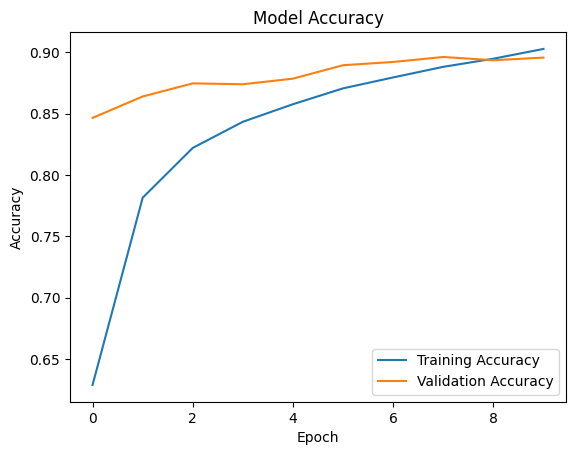

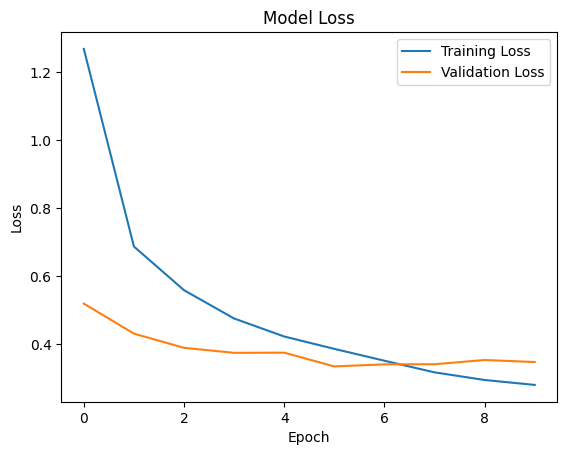

In [4]:






import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()











In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import math
import os

# --------------------------
# 1. Define dataset paths
# --------------------------
train_dir = r"C:\Users\fomal\Downloads\archive\subset_dataset\train"
val_dir = r"C:\Users\fomal\Downloads\archive\subset_dataset\validation"

# --------------------------
# 2. Data augmentation
# --------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalize
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# --------------------------
# 3. Create generators for all 39 classes
# --------------------------
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',  # 39-class output
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# --------------------------
# 4. Steps per epoch for progress
# --------------------------
train_steps = math.ceil(train_generator.samples / train_generator.batch_size)
val_steps = math.ceil(val_generator.samples / val_generator.batch_size)

# --------------------------
# 5. Build the model
# --------------------------
num_classes = 39  # 0-9, A-Z, symbols
input_shape = (64, 64, 3)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # must match 39 classes
])

# --------------------------
# 6. Compile the model
# --------------------------
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --------------------------
# 7. Define model checkpoint
# --------------------------
checkpoint = ModelCheckpoint(
    "handwriting_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# --------------------------
# 8. Train the model
# --------------------------
model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=10,
    callbacks=[checkpoint],
    verbose=1  # terminal progress bar
)


Found 39000 images belonging to 39 classes.
Found 26418 images belonging to 39 classes.


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4914 - loss: 1.8129
Epoch 1: val_accuracy improved from None to 0.82720, saving model to handwriting_model.h5


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 150s 121ms/step - accuracy: 0.6331 - loss: 1.2486 - val_accuracy: 0.8272 - val_loss: 0.5583
Epoch 2/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7751 - loss: 0.7242
Epoch 2: val_accuracy improved from 0.82720 to 0.85782, saving model to handwriting_model.h5


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 154s 126ms/step - accuracy: 0.7869 - loss: 0.6830 - val_accuracy: 0.8578 - val_loss: 0.4370
Epoch 3/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8189 - loss: 0.5717
Epoch 3: val_accuracy improved from 0.85782 to 0.87149, saving model to handwriting_model.h5


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 152s 125ms/step - accuracy: 0.8235 - loss: 0.5539 - val_accuracy: 0.8715 - val_loss: 0.3939
Epoch 4/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8387 - loss: 0.4870
Epoch 4: val_accuracy improved from 0.87149 to 0.88849, saving model to handwriting_model.h5


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 154s 126ms/step - accuracy: 0.8453 - loss: 0.4730 - val_accuracy: 0.8885 - val_loss: 0.3352
Epoch 5/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8577 - loss: 0.4344
Epoch 5: val_accuracy improved from 0.88849 to 0.89083, saving model to handwriting_model.h5


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 120s 98ms/step - accuracy: 0.8580 - loss: 0.4321 - val_accuracy: 0.8908 - val_loss: 0.3256
Epoch 6/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8667 - loss: 0.4000
Epoch 6: val_accuracy did not improve from 0.89083
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 119s 97ms/step - accuracy: 0.8660 - loss: 0.4027 - val_accuracy: 0.8865 - val_loss: 0.3396
Epoch 7/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8734 - loss: 0.3769
Epoch 7: val_accuracy improved from 0.89083 to 0.90453, saving model to handwriting_model.h5


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 212s 174ms/step - accuracy: 0.8731 - loss: 0.3784 - val_accuracy: 0.9045 - val_loss: 0.3023
Epoch 8/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8773 - loss: 0.3645
Epoch 8: val_accuracy did not improve from 0.90453
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 429s 352ms/step - accuracy: 0.8768 - loss: 0.3673 - val_accuracy: 0.8782 - val_loss: 0.3302
Epoch 9/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8844 - loss: 0.3436
Epoch 9: val_accuracy did not improve from 0.90453
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 237s 195ms/step - accuracy: 0.8838 - loss: 0.3457 - val_accuracy: 0.8958 - val_loss: 0.3283
Epoch 10/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8830 - loss: 0.3426
Epoch 10: val_accuracy did not improve from 0.90453
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 241s 198ms/step - accuracy: 0.8844 - loss: 0.3397 - val_accuracy: 0.9013 - val_loss: 0.3075


In [14]:
# ===============================
# Step 5A: Load Model and Setup
# ===============================
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # ✅ fixed import

# -------------------------------
# 1. Load the trained model
# -------------------------------
model_path = r"C:\Users\fomal\Downloads\archive\subset_dataset\models\best_model_subset.keras"

if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model file not found at {model_path}")
else:
    print("✅ Model file found!")

model = load_model(model_path)
print("✅ Model loaded successfully!")

# -------------------------------
# 2. Recreate class mapping
# -------------------------------
subset_base = r"C:\Users\fomal\Downloads\archive\subset_dataset"
train_dst = os.path.join(subset_base, "train")

# Recreate ImageDataGenerator (no training, just structure)
img_height, img_width = 64, 64
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(
    train_dst,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Create mapping from numeric index → class name
class_mapping = {v: k for k, v in train_data.class_indices.items()}
print("✅ Class mapping created!")


✅ Model file found!
✅ Model loaded successfully!
Found 39000 images belonging to 39 classes.
✅ Class mapping created!


In [15]:


import os
import numpy as np
import csv
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory

# ==========================
# Path Setup
# ==========================
subset_path = r"C:\Users\fomal\Downloads\archive\subset_dataset"
val_dir = os.path.join(subset_path, "validation")

# ==========================
# Fast Batch-Based Evaluation
# ==========================
print("\n🚀 Running fast batch-based evaluation...")

datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Predict all validation images in batches
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Compare with true labels
true_classes = val_generator.classes
accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"\n🎯 Overall Validation Accuracy (Batch-based): {accuracy:.2f}%")

# ==========================
# Detailed Per-Class Evaluation (Slower)
# ==========================
print("\n🔍 Running detailed per-class evaluation...")

def predict_image(model, img_path, target_size=(64, 64)):
    """Predict class of one image."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array, verbose=0)
    predicted_class = class_mapping[np.argmax(prediction)]
    return predicted_class

# List to store per-class results
per_class_results = []

total_images = 0
correct_predictions = 0

for class_name in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_name)
    if os.path.isdir(class_path):
        print(f"\n🔍 Class: {class_name}")
        class_correct = 0
        class_total = 0

        for img_file in os.listdir(class_path):
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(class_path, img_file)
            predicted_class = predict_image(model, img_path)

            if predicted_class == class_name:
                class_correct += 1
            class_total += 1

            print(f"  🖼️ {img_file} → Predicted: {predicted_class}")

        acc = (class_correct / class_total * 100) if class_total > 0 else 0
        print(f"✅ Accuracy for {class_name}: {acc:.2f}%")

        # Save to results list
        per_class_results.append([class_name, class_total, class_correct, f"{acc:.2f}"])

        total_images += class_total
        correct_predictions += class_correct

overall_acc = (correct_predictions / total_images * 100) if total_images > 0 else 0
print(f"\n🎯 Overall Validation Accuracy (Per-Class Loop): {overall_acc:.2f}%")

# ==========================
# Save Per-Class Accuracy to CSV
# ==========================
csv_path = os.path.join(subset_path, "per_class_accuracy.csv")
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Class", "Total Images", "Correct Predictions", "Accuracy (%)"])
    writer.writerows(per_class_results)

print(f"\n💾 Per-class accuracy saved to CSV: {csv_path}")
print("\n✅ Evaluation complete!")



🚀 Running fast batch-based evaluation...
Found 26418 images belonging to 39 classes.
413/413 ━━━━━━━━━━━━━━━━━━━━ 54s 130ms/step

🎯 Overall Validation Accuracy (Batch-based): 89.61%

🔍 Running detailed per-class evaluation...

🔍 Class: #
  🖼️ __0_1118489.png → Predicted: #
  🖼️ __0_121440_1.png → Predicted: #
  🖼️ __0_1274730_1.png → Predicted: #
  🖼️ __0_142135_1.png → Predicted: #
  🖼️ __0_1546392_1.png → Predicted: #
  🖼️ __0_2035617_1.png → Predicted: #
  🖼️ __0_2312097_1.png → Predicted: #
  🖼️ __0_2312748.png → Predicted: #
  🖼️ __0_2407604.png → Predicted: #
  🖼️ __0_2453928_1.png → Predicted: #
  🖼️ __0_2988102_1.png → Predicted: #
  🖼️ __0_3537415.png → Predicted: #
  🖼️ __0_3933119.png → Predicted: #
  🖼️ __0_4395651.png → Predicted: #
  🖼️ __0_487085_1.png → Predicted: #
  🖼️ __0_5122500.png → Predicted: #
  🖼️ __0_5487022.png → Predicted: #
  🖼️ __0_5560842_1.png → Predicted: #
  🖼️ __0_5730665.png → Predicted: #
  🖼️ __0_5730665_1.png → Predicted: #
  🖼️ __0_5907262.png →

In [30]:
# ===============================
# predict_phone_images_cleaned.py
# ===============================
import os
import numpy as np
import csv
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------------
# 1. Paths
# -------------------------------
model_path = r"C:\Users\fomal\Downloads\archive\subset_dataset\models\best_model_subset.keras"
image_folder = r"C:\Users\fomal\Downloads\image for ai lab"  # folder with phone photos
output_csv = r"C:\Users\fomal\OneDrive\Documents\New folder\AI lab\predictions.csv"
train_folder = r"C:\Users\fomal\Downloads\archive\subset_dataset\train"

# -------------------------------
# 2. Load model
# -------------------------------
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model file not found at {model_path}")
model = load_model(model_path)
print("✅ Model loaded successfully!")

# -------------------------------
# 3. Recreate class mapping
# -------------------------------
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
class_mapping = {v: k for k, v in train_gen.class_indices.items()}
print("✅ Class mapping created!\n")

# -------------------------------
# 4. Image preprocessing
# -------------------------------
def preprocess_phone_image(image_path, target_size=(64, 64)):
    """
    Preprocess phone-captured image of a single character to model-ready format.
    """
    img = cv2.imread(image_path)

    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 2: Denoise (helps with phone blur)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Step 3: Normalize brightness/contrast
    gray = cv2.equalizeHist(gray)

    # Step 4: Resize to model input (keeping aspect ratio)
    resized = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)

    # Step 5: Convert to 3 channels (since model trained on RGB)
    rgb_img = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

    # Normalize to [0,1]
    img_array = rgb_img.astype("float32") / 255.0

    # Add batch dimension
    return np.expand_dims(img_array, axis=0)

# -------------------------------
# 5. Predict function
# -------------------------------
def predict_image(model, img_path):
    preprocessed = preprocess_phone_image(img_path)
    pred = model.predict(preprocessed, verbose=0)
    pred_class_idx = np.argmax(pred, axis=1)[0]
    return class_mapping[pred_class_idx]

# -------------------------------
# 6. Run predictions
# -------------------------------
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
results = []

print("🚀 Predicting images...\n")

for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    try:
        predicted_char = predict_image(model, img_path)
        print(f"✅ {img_file} → Predicted: {predicted_char}")
        results.append([img_file, predicted_char])
    except Exception as e:
        print(f"⚠️ {img_file} Error: {e}")
        results.append([img_file, f"Error: {e}"])

# -------------------------------
# 7. Save predictions
# -------------------------------
with open(output_csv, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["Image", "Predicted_Character"])
    writer.writerows(results)

print(f"\n📂 All predictions saved to {output_csv}")
print("✅ Done!")


✅ Model loaded successfully!
Found 39000 images belonging to 39 classes.
✅ Class mapping created!

🚀 Predicting images...

✅ WhatsApp Image 2025-10-10 at 14.59.03_a1969561.jpg → Predicted: @
✅ WhatsApp Image 2025-10-10 at 22.49.03_bcb7cc99.jpg → Predicted: @
✅ WhatsApp Image 2025-10-10 at 22.51.21_c3ff2eaa.jpg → Predicted: @
✅ WhatsApp Image 2025-10-10 at 22.51.22eaa.jpg → Predicted: @
✅ WhatsApp Image 2025-10-10 at 22.56.29_7.jpg → Predicted: @
✅ WhatsApp Image 2025-10-10 at 29e8a7.jpg → Predicted: @
✅ WhatsApp Image 2025-10-10 at c207b9d6.jpg → Predicted: @

📂 All predictions saved to C:\Users\fomal\OneDrive\Documents\New folder\AI lab\predictions.csv
✅ Done!


In [ ]:
# multi_char_predict.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# =========================
# Load your trained model
# =========================
model = load_model("your_trained_model.h5")  # Change to your model path

# Class mapping dictionary
class_mapping = {
    0: '#', 1: '$', 2: '&', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6',
    10: '7', 11: '8', 12: '9', 13: '@', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E',
    19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N',
    28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X',
    37: 'Y', 38: 'Z'
}

# =========================
# Preprocessing function for single character
# =========================
def preprocess_char(char_img, target_size=(64,64)):
    """Resize, center, normalize, and prepare single character for prediction."""
    h, w = char_img.shape
    h_ratio, w_ratio = target_size[0] / h, target_size[1] / w
    scale = min(h_ratio, w_ratio)
    new_w, new_h = int(w * scale), int(h * scale)
    char_img = cv2.resize(char_img, (new_w, new_h))

    canvas = np.zeros(target_size, dtype=np.uint8)
    x_offset = (target_size[1] - new_w) // 2
    y_offset = (target_size[0] - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img

    # Normalize and add batch/channel dimension
    canvas = canvas / 255.0
    canvas = np.expand_dims(canvas, axis=(0, -1))
    return canvas

# =========================
# Predict characters in multi-character image
# =========================
def predict_multi_char(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (5,5), 0)
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours of all characters
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No characters found!")

    # Sort contours left-to-right
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])

    predicted_text = ""
    char_imgs = []

    for x, y, w, h in bounding_boxes:
        char_crop = thresh[y:y+h, x:x+w]
        char_imgs.append(char_crop)
        processed = preprocess_char(char_crop)
        pred = model.predict(processed)
        pred_class = np.argmax(pred, axis=1)[0]
        predicted_text += class_mapping[pred_class]

    # Save output
    with open("output.txt", "w") as f:
        f.write(predicted_text)
    print(f"✅ Predicted Text: {predicted_text}")
    print("💾 Saved to output.txt")

    # Visualize
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_text}")
    plt.axis('off')
    plt.show()

# =========================
# Main
# =========================
if __name__ == "__main__":
    image_path = "phone_word.jpg"  # Your phone photo of multiple characters
    predict_multi_char(image_path)
